In [25]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from BlackScholes import *
from GBMSim import *
from random import Random
from scipy import stats  
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = []
        
        for idx in range(len(x_train)):
             y_train.append(f(x_train[idx], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [27]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
            y_test_.append(f(x_test[idx], time))
            
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [31]:
# specify the portfolio
KC = 110    # Call strike
KP = 90     # Put strike
lb = 0.01
ub = 400
r  = 0
T  = 2
sigma = 0.3
nt = 11
S0 = 100
n_sim_dt = 100


In [11]:
# specify the portfolio
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, y, sigma, 0)[0]
portfolio['put']['price']= lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, y, sigma, 0)[0]
portfolio['call']['weight']=2.0
portfolio['put']['weight']=-1.0

In [12]:
# prepare training and test data
training_number= 100
testing_number = 50
x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

In [32]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters to the default intensity model    
def_model['gamma_0'] = 0.01
def_model['gamma_1'] = 1.2
def_model['calibrate'] = False    
def_model['recovery'] = 0.4

sim_params['n_sim_dt'] = n_sim_dt # number of Euler stpes
sim_params['M']  = 1000      # number of paths
sim_params['nt'] = nt        # number of exposure dates

timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

sim_params['timegrid']= timegrid # time grid of exposure dates

In [16]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

/Users/matthewdixon/Downloads/BM/Bayesian-modeling/BlackScholes.py:16: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.2358298]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 111, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.82093109]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 105, 'nit': 13, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.25720529]),

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.21232551]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([21.84470266]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.25504617]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

In [28]:
def CVA_simulation(sim_params, model_params, def_model):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    gamma_1  = def_model['gamma_1']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    
    pi = {}
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    if (def_model['calibrate']):
        x  = np.exp(S0/S)**gamma_1
        # default probability (assumed to be estimated from credit spread)
        dt = timegrid[1]-timegrid[0] 
        f  = lambda y: np.abs(np.mean(np.prod(x**(-y*dt), axis=0)) - def_model['p']) 
        res = sp.optimize.basinhopping(f, 0.1, niter=10)
        i = 1   
        while (abs(res.fun) >1e-3):   
          res = sp.optimize.basinhopping(f, 0.1, niter=100*i)
          i *= 2
        gamma_0= res.x[0]
        print("calibration:", gamma_0, gamma_1, f(gamma_0), res.fun)  
    
    
    for m in range(M):  
      i = 1 
      exp_factor=1
        
      for time in timegrid[1:]:
        dt = timegrid[i]-timegrid[i-1] 
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
       
           if key=='call':
              v_ += portfolio[key]['weight']*bsformula(1, S_, KC, r, time, sigma, 0)[0]
           else:
              v_ += portfolio[key]['weight']*bsformula(-1, S_, KP, r, time, sigma, 0)[0]
        pi['tilde'][i-1,m] = np.maximum(pred_,0)
        pi['exact'][i-1,m] = np.maximum(v_,0)
        pi['tilde_var'][i-1,m] =var_ 
          
        # default intensity model
        gamma[i-1,m] = gamma_0*(S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i-1,m]= gamma[i-1,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
   
    for time in timegrid[1:]:
        dt = timegrid[i+1]-timegrid[i]
        mu_tilde = np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['tilde'] += mu_tilde
        std_err_MC = np.std(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt/np.sqrt(M)
        CVA['tilde_up'] += mu_tilde + 2.0*std_err_MC
        CVA['tilde_down'] += mu_tilde - 2.0*std_err_MC
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['tilde_up'] *= (1-def_model['recovery'])
    CVA['tilde_down'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
        
    return(CVA)

## One year CVA with UQ

In [33]:
J= 1   # number of outer simulations (from prior). Set J=1 for one year CVA without UQ
M = 10 # number of middle simulations. Set M= 0 for CVA_0 with UQ 
CVA_1 = []
CVA_0 = []
gamma_1= np.array([0.0]*J, dtype='float32')

# Sample from prior distribution using 
# non-centered chi-squared random variates
gamma_1 = (1.2 + 1.0*np.random.randn(J))**2 

for j in range(J): # outer loop
    
    def_model['gamma_0'] = 0.02
    def_model['gamma_1'] = gamma_1[j] 
    model_params['t0'] = 0.0
    sim_params['timegrid'] = timegrid
    CVA_0.append(CVA_simulation(sim_params, model_params, def_model))
    
    S = gbm(S0, r, sigma, 1.0, n_sim_dt, M)
    model_params['t0'] = 1.0
    sim_params['timegrid'] = timegrid[5:]
    for m in range(M): # middle loop
        model_params['S0'] = S[-1, m]
        CVA_1.append(CVA_simulation(sim_params, model_params, def_model))

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [34]:
CVA

[{'tilde': array([0.01504222], dtype=float32),
  'exact': array([0.02620349], dtype=float32),
  'tilde_up': array([0.01738534], dtype=float32),
  'tilde_down': array([0.01269909], dtype=float32)},
 {'tilde': array([0.5998269], dtype=float32),
  'exact': array([0.6995865], dtype=float32),
  'tilde_up': array([0.6138042], dtype=float32),
  'tilde_down': array([0.58584946], dtype=float32)},
 {'tilde': array([0.00048084], dtype=float32),
  'exact': array([0.00088726], dtype=float32),
  'tilde_up': array([0.000731], dtype=float32),
  'tilde_down': array([0.00023068], dtype=float32)},
 {'tilde': array([0.05529058], dtype=float32),
  'exact': array([0.09132233], dtype=float32),
  'tilde_up': array([0.06033953], dtype=float32),
  'tilde_down': array([0.05024163], dtype=float32)},
 {'tilde': array([0.00011632], dtype=float32),
  'exact': array([0.00027999], dtype=float32),
  'tilde_up': array([0.00020343], dtype=float32),
  'tilde_down': array([2.920407e-05], dtype=float32)},
 {'tilde': array([

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0,0.5,'density')

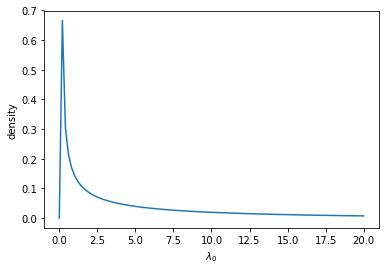

In [34]:
# plot fitted distribution of gamma_0
lnspc = np.linspace(0, 20.0, 100)
ab,bb,cb,db = stats.beta.fit(gamma_0)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='$\\lambda_0$')
plt.xlabel('$\\lambda_0$')
plt.ylabel('density')

In [39]:
np.max(CVA_1_yr-CVA), np.min(CVA_1_yr-CVA)

(72.24025230407715, -10.225179290771484)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


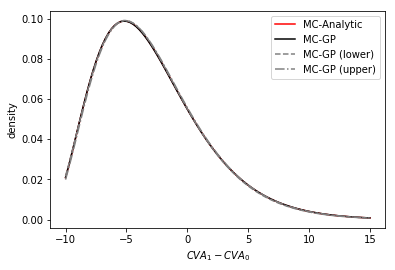

In [40]:
# plot one year incremental CVA distribution
lnspc = np.linspace(-10.0, 15, 100)

ab,bb,cb,db = stats.beta.fit(CVA_1_yr-CVA)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-Analytic', color='r')

ab,bb,cb,db = stats.beta.fit(CVA_1_yr_tilde-CVA_tilde)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP', color='k')

ab,bb,cb,db = stats.beta.fit(CVA_1_yr_tilde_up-CVA_tilde_up)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (lower)', color="grey", linestyle='--')

ab,bb,cb,db = stats.beta.fit(CVA_1_yr_tilde_down-CVA_tilde_down)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('$CVA_1 - CVA_0$')
plt.ylabel('density')
plt.legend()
plt.show()


Text(0,0.5,'density')

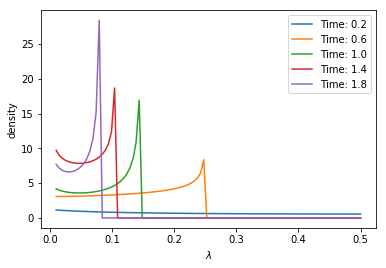

In [47]:
i =0 
for time in timegrid[1::2]:
    
# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
    
    lnspc = np.linspace(0.01, 0.5, 100)

    ab,bb,cb,db = stats.beta.fit(dPD[i,:,:])  
    pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    plt.plot(lnspc, pdf_beta, label='Time: ' + str(time[0]))
    i+=1
    
 
plt.legend()
plt.xlabel('$\\lambda$')
plt.ylabel('density')

In [49]:
CVA_VaR = []
CVA_VaR_tilde = []
CVA_VaR_tilde_down = []
CVA_VaR_tilde_up = []

for j in range(J):
  s_sorted=np.sort(CVA_1_yr[:,j]-CVA[j])
  s_sorted_tilde=np.sort(CVA_1_yr_tilde[:,j]-CVA_tilde[j])
  s_sorted_tilde_down=np.sort(CVA_1_yr_tilde_down[:,j]-CVA_tilde_down[j])
  s_sorted_tilde_up=np.sort(CVA_1_yr_tilde_up[:,j]-CVA_tilde_up[j])
  quantiles = np.array([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999])
  idx = np.array(len(s_sorted)*quantiles[9], dtype=int)
  CVA_VaR.append(s_sorted[idx])
  CVA_VaR_tilde.append(s_sorted_tilde[idx])
  CVA_VaR_tilde_down.append(s_sorted_tilde_down[idx])
  CVA_VaR_tilde_up.append(s_sorted_tilde_up[idx])


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


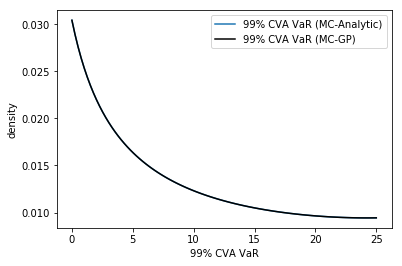

In [50]:
lnspc = np.linspace(0, 25.0, 100)

ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='99% CVA VaR (MC-Analytic)')
ab,bb,cb,db = stats.beta.fit(np.array(CVA_VaR_tilde))  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='99% CVA VaR (MC-GP)', color='k')


plt.xlabel('99% CVA VaR')
plt.ylabel('density')
plt.legend()

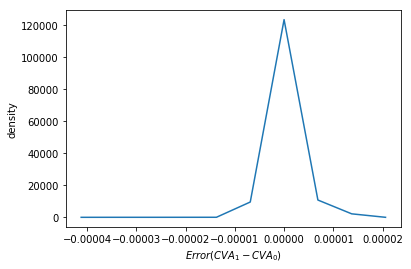

In [53]:
s = (CVA_1_yr_tilde-CVA_tilde) - (CVA_1_yr - CVA)   # generate your data sample with N elements
p, x = np.histogram(s, bins=10, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = sp.interpolate.UnivariateSpline(x, p, s=1)
plt.plot(x, f(x))
plt.xlabel('$Error(CVA_1 - CVA_0)$')
plt.ylabel('density')
plt.show()